# HQNN-Quanv

Running on local machine, preferably using Pennylane's `lightning.qubit`.


## Key notes on this model

- The ultimate goal of the model training is to find a **measurement basis** (by tweaking variational gate parameters) that tells us the most information about a fragment of a picture confined by the quantum kernel.
- Finally, for each wire, the expectation value of an **arbitrary operator** is calculated to obtain the classical output. As it is a real number, **it represents the kernel’s output pixel**, while each wire yields a **different image channel**. For instance, a quanvolutional kernel of size 2 × 2 has a 4-qubit circuit, which transforms one input image into _four images of reduced size_.


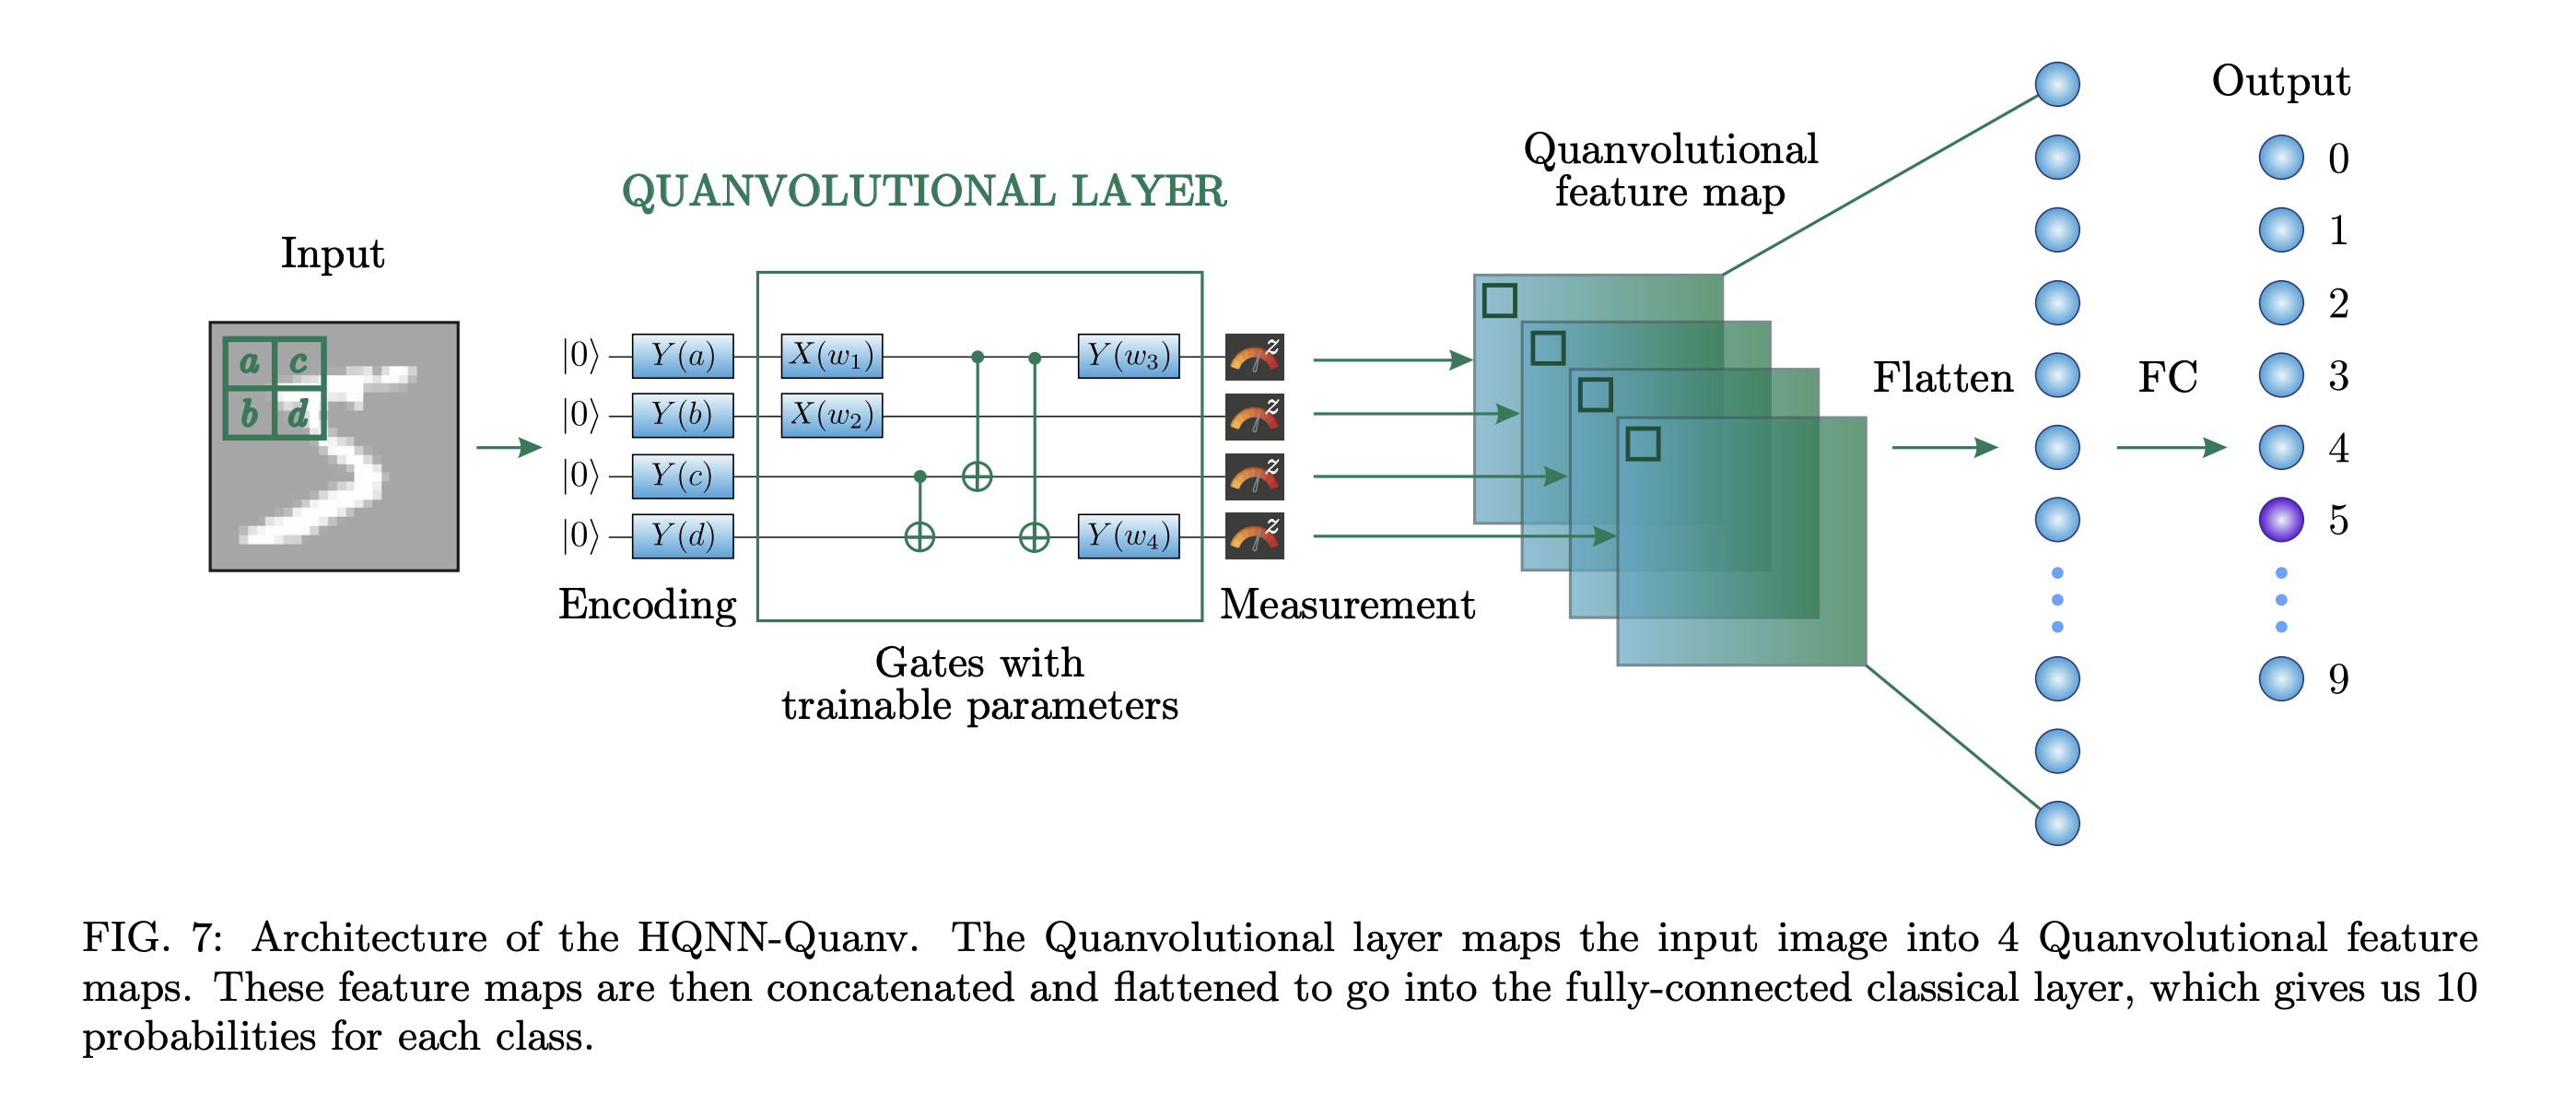


## Structure of the quantum kernel

First embed the pixels in the kernel to qubits, one qubit per pixel (2x2 kernel -> 4 qubits).

- This embedding will be done by first scaling the (0, 1) pixel value to (0, π) and then doing a Ry rotation by the scaled angle.

Then the variational circuit has 4 **parametrized** single-qubit rotations, and three CNOT gates (for the example of a 2x2 matrix)

Finally we measure the **expectation value** of the **Pauli-Z** operator for each qubit.

- This creates 4 output channels, each with one expectation value. "Each channel is a picture with 4 × 4 pixels." **what does this mean?**

The four output channels are then **flattened** and passed to a dense layer to generate probabilities for different classes.


In [1]:
# Imports
import torch.nn as nn
import pennylane as qml
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import random
import io
from PIL import Image
import os
from datetime import datetime

In [2]:
# Load the dataset
import kagglehub

dataset_path = kagglehub.dataset_download("andrewmvd/medical-mnist")
print("Path to Medical MNIST dataset files:", dataset_path)

Path to Medical MNIST dataset files: /Users/jaimanmunshi/.cache/kagglehub/datasets/andrewmvd/medical-mnist/versions/1


In [3]:
class QuanvolutionalLayer(nn.Module):
    '''
    A PyTorch module for the quanvolutional layer.
    '''

    def __init__(self, kernel_size=4, depth=1, draw_circuit=False):
        '''
        Args:
            kernel_size (int): The size of the kernel. e.g. passing 2 would result in a 2x2 kernel.
            depth (int): The number of repetitions of variational sections to use. 
                - This linearly affects the number of trainable parameters in the quanvolutional layer.
            device (str): The PennyLane device to use.
        '''
        super().__init__()

        self.kernel_size = kernel_size
        self.n_qubits = kernel_size**2
        self.depth = depth
        
        self.draw_circuit = draw_circuit

        # Learnable weights for the variational circuit
        self.weights = nn.Parameter(torch.randn(self.depth, self.n_qubits))

        
        # --- Creating the PennyLane device to run circuits on ---
        dev = qml.device('lightning.qubit', wires=self.n_qubits)

        @qml.qnode(dev, interface='torch', diff_method='adjoint')
        def quantum_circuit(inputs, weights):
            # --- Encoding the inputs into Y-rotation angles ---
            # Scale inputs to [0, pi] range
            scaled_inputs = inputs * torch.pi
            qml.AngleEmbedding(scaled_inputs, wires=range(self.n_qubits), rotation='Y')

            # --- Define the Variational layers (trainable params) ---
            # Reshape the weights for easier indexing
            weights = weights.reshape(self.depth, self.n_qubits)
            for layer_id in range(self.depth):
                # --- TODO: Support other kernel sizes ---
                # X gates with trainable parameters on qubits 0 and 1
                qml.RX(weights[layer_id, 0], wires=0)
                qml.RX(weights[layer_id, 1], wires=1)
                # CNOT gates
                qml.CNOT(wires=[2, 3])
                qml.CNOT(wires=[0, 2])
                qml.CNOT(wires=[0, 3])
                # Y gates with trainable parameters on qubits 0 and 3
                qml.RY(weights[layer_id, 2], wires=0)
                qml.RY(weights[layer_id, 3], wires=3)

                # separate the layers with a barrier
                qml.Barrier(wires=range(self.n_qubits))

            # --- Measurement of the qubits ---
            return [qml.expval(qml.PauliZ(i)) for i in range(self.n_qubits)]

        self.quantum_kernel = quantum_circuit

        if self.draw_circuit:
            # --- Display the circuit for visualization ---
            print("--- Quantum Circuit Structure ---")
            # Create dummy inputs and weights for drawing
            dummy_inputs = torch.zeros(self.n_qubits)
            dummy_weights = torch.zeros(self.depth * self.n_qubits)

            # Draw the circuit
            fig, ax = qml.draw_mpl(quantum_circuit)(dummy_inputs, dummy_weights)
            plt.show()
            print("---------------------------------")

    def forward(self, x):
        '''
        Forward pass for the quanvolutional layer.
        '''

        # assume x is a batch of patches of shape (batch, n_qubits)
        batch_size = x.shape[0]
        weights = torch.zeros(self.depth * self.n_qubits, device=x.device, dtype=x.dtype)

        outputs = []
        for i in range(batch_size):
            out = torch.tensor(self.quantum_kernel(x[i], weights), device=x.device, dtype=x.dtype)
            outputs.append(out)

        return torch.stack(outputs)

--- Quantum Circuit Structure ---


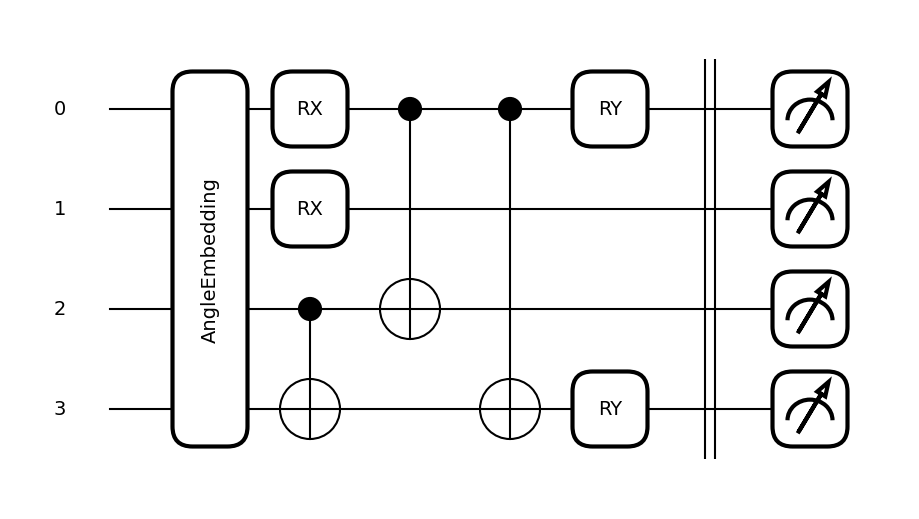

---------------------------------
Input shape: torch.Size([3, 4])
Output shape: torch.Size([3, 4])
Output: tensor([[-0.3542, -0.8360,  0.3384,  0.0701],
        [-0.8854, -0.1673,  0.8733,  0.1174],
        [ 0.5539, -0.4835, -0.3538, -0.1253]])


In [4]:
# --- Testing the Quanvolutional Layer ---
kernel_size = 2
depth = 1
batch_size = 3

layer = QuanvolutionalLayer(kernel_size=kernel_size, depth=depth, draw_circuit=True)
dummy_input = torch.rand(batch_size, kernel_size**2)

output = layer(dummy_input)


print("Input shape:", dummy_input.shape)
print("Output shape:", output.shape)
print("Output:", output)

## Constructing the full model


In [9]:
class HQNNQuanv(nn.Module):
    def __init__(self, image_size=244, kernel_size=2, depth=1, n_classes=6, draw_circuit=False):
        super().__init__()

        self.kernel_size = kernel_size
        self.n_qubits = kernel_size ** 2
        self.depth = depth

        # Quanvolutional layer
        self.quanv = QuanvolutionalLayer(kernel_size=kernel_size, depth=depth, draw_circuit=draw_circuit)

        # Calculate output size after sliding the kernel
        # For stride=1, padding=0:
        self.feature_map_size = image_size - kernel_size + 1
        self.n_channels = self.n_qubits * 3     # 4*3=12 for 2x2 kernel

        # Fully connected layer
        self.Dense = nn.Linear(self.n_channels * self.feature_map_size**2, n_classes)

    def forward(self, x):
        # x: (batch, 3, H, W)
        batch_size = x.shape[0]
        patches = []
        # Extract patches and apply quanvolution
        for idx, img in enumerate(x):
            if idx % 1 == 0:
                print(f"Processing image {idx+1}/{batch_size} in batch...")
            # img: (3, H, W)
            img_patches = []
            for c in range(img.shape[0]):
                for i in range(self.feature_map_size):
                    for j in range(self.feature_map_size):
                        patch = img[c, i:i+self.kernel_size, j:j+self.kernel_size].reshape(-1)
                        img_patches.append(patch)

            img_patches = torch.stack(img_patches)      # (n_patches, n_qubits)
            quanv_out = self.quanv(img_patches)         # (n_patches, n_qubits)
            quanv_out = quanv_out.transpose(0, 1)       # (n_qubits, n_patches)
            quanv_out = quanv_out.reshape(self.n_channels, self.feature_map_size, self.feature_map_size)
            patches.append(quanv_out)

        x = torch.stack(patches)    # (batch_size, n_channels, feature_map_size, feature_map_size)

        x = x.view(batch_size, -1)  # Flatten

        x = self.Dense(x) # Fully connected layer

        return x

--- Quantum Circuit Structure ---


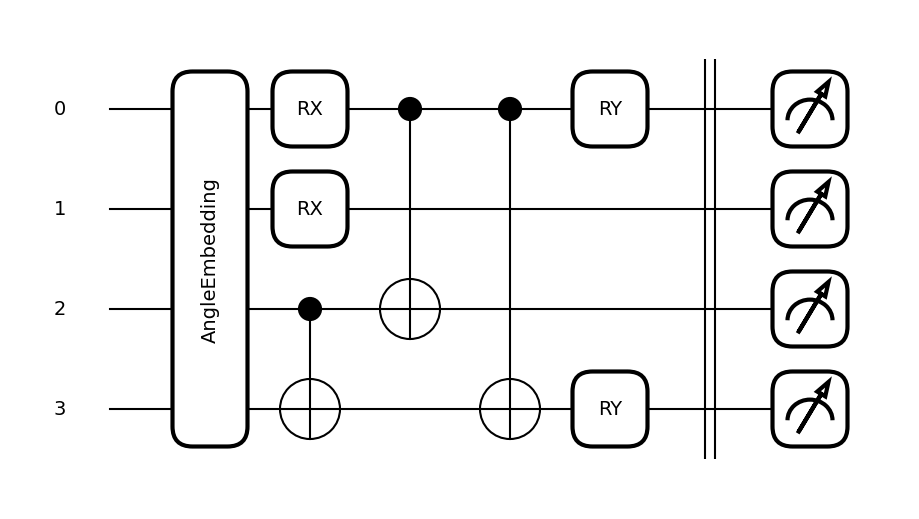

---------------------------------


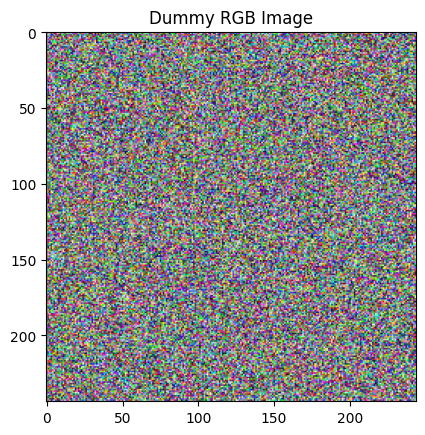

Processing image 1/2 in batch...
Processing image 2/2 in batch...
Input shape: torch.Size([2, 3, 244, 244])
Output shape: torch.Size([2, 6])
Output: tensor([[ 0.4071, -0.5983, -0.0882,  0.0782,  0.1674,  0.1954],
        [ 0.4460,  0.3659, -0.5268, -0.0373, -0.2365, -0.1403]],
       grad_fn=<AddmmBackward0>)


In [10]:
# --- Testing the full HQNNQuanv model ---
batch_size = 2
image_size = 244
kernel_size = 2
depth = 1
n_classes = 6

model = HQNNQuanv(image_size=image_size, kernel_size=kernel_size, depth=depth, n_classes=n_classes, draw_circuit=True)

# Create a dummy batch of grayscale images (values ranging [0,1])
dummy_images = torch.rand(batch_size, 3, image_size, image_size)
# Visualize one of the dummy images
plt.imshow(dummy_images[0].permute(1, 2, 0).detach().numpy())
plt.title("Dummy RGB Image")
plt.show()

# Run the test forward passs
output = model(dummy_images)

print("Input shape:", dummy_images.shape)
print("Output shape:", output.shape)
print("Output:", output)


## Training


In [11]:
def train_hqnn_quanv(model, train_loader, test_loader, device, epochs=20, learning_rate=0.01, plot=True):
    import matplotlib.pyplot as plt
    from IPython.display import display
    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # --- Live Plotting Setup (Optional) ---
    if plot:
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Loss", color='b')
        ax2.set_ylabel("Accuracy (%)", color='r')
        ax1.tick_params(axis='y', labelcolor='b')
        ax2.tick_params(axis='y', labelcolor='r')
        line1, = ax1.plot([], [], 'b-', label='Training Loss')
        line2, = ax2.plot([], [], 'r.-', label='Test Accuracy')
        fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
        plot_display = display(fig, display_id=True)
    train_losses, train_steps = [], []
    test_accuracies, test_epochs = [], []
    steps_per_epoch = len(train_loader)
    global_step = 0

    for epoch in range(epochs):
        model.train() # put the model in training mode
        train_correct = 0
        train_total = 0
        running_loss = 0.0
        for step, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            train_losses.append(loss.item())
            train_steps.append(epoch + step / steps_per_epoch)
            global_step += 1

            # Print metrics every 10 steps
            if (step + 1) % 10 == 0 or (step + 1) == steps_per_epoch:
                avg_loss = running_loss / (step + 1)
                acc = train_correct / train_total
                print(f"Epoch [{epoch+1}/{epochs}] Step [{step+1}/{steps_per_epoch}] "
                      f"Loss: {avg_loss:.4f} | Acc: {acc:.3f}")
                if plot:
                    line1.set_data(train_steps, train_losses)
                    line2.set_data(test_epochs, test_accuracies)
                    ax1.relim()
                    ax1.autoscale_view()
                    ax2.relim()
                    ax2.autoscale_view()
                    plot_display.update(fig)
        train_acc = train_correct / train_total
        # --- Evaluation ---
        model.eval() # set model to evaluation mode
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
        test_acc = test_correct / test_total
        avg_epoch_loss = running_loss / len(train_loader)
        test_accuracies.append(test_acc * 100)
        test_epochs.append(epoch + 1)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_epoch_loss:.4f} | "
              f"Train Acc: {train_acc:.3f} | Test Acc: {test_acc:.3f}")
        if plot:
            line1.set_data(train_steps, train_losses)
            line2.set_data(test_epochs, test_accuracies)
            ax1.relim()
            ax1.autoscale_view()
            ax2.relim()
            ax2.autoscale_view()
            plot_display.update(fig)
    if plot:
        buf = io.BytesIO()
        fig.savefig(buf, format='png')
        plot_bytes = buf.getvalue()
        buf.close()
        plt.close(fig)
    print('Finished Training')
    return model, plot_bytes


In [12]:
# --- Data Preparation ---
# Preprocessing: random rotation, horizontal flip, resize, tensor conversion
transform = transforms.Compose([
    transforms.Resize((244, 244)), # Original size
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

# Load the dataset using torchvision's ImageFolder
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
print(f"Total images found: {len(full_dataset)}")

# Split into train and test (80% train, 20% test)
train_dataset, test_dataset = random_split(full_dataset, [0.8, 0.2])

dataset_portion = 1.00

# Get the specified portions of the dataset
train_dataset = torch.utils.data.Subset(train_dataset, range(int(len(train_dataset) * dataset_portion)))
test_dataset = torch.utils.data.Subset(test_dataset, range(int(len(test_dataset) * dataset_portion)))

# DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Total images found: 58954


In [13]:
# --- Hyperparameters ---
hyperparams = {
    'image_size': 244,
    'kernel_size': 2,
    'depth': 1,
    'n_classes': 6,
}


# --- Model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HQNNQuanv(
    image_size=hyperparams['image_size'], 
    kernel_size=hyperparams['kernel_size'], 
    depth=hyperparams['depth'], 
    n_classes=hyperparams['n_classes']
).to(device)



# Training parameters
epochs = 10
learning_rate = 0.01

# Warning: the following cell trains the model, it may take a long time to run


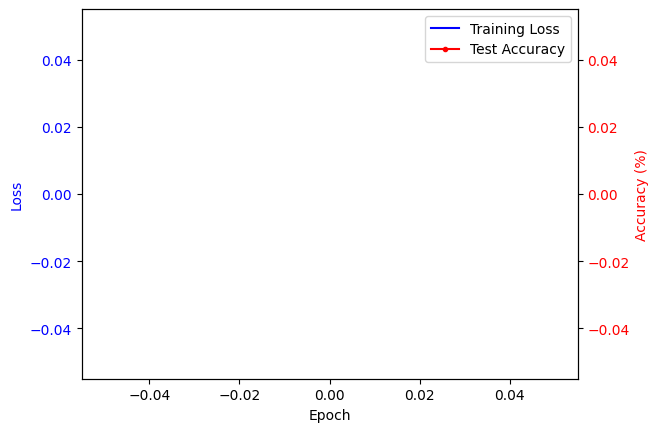

Processing image 1/32 in batch...
Processing image 2/32 in batch...
Processing image 3/32 in batch...
Processing image 4/32 in batch...
Processing image 5/32 in batch...
Processing image 6/32 in batch...
Processing image 7/32 in batch...
Processing image 8/32 in batch...
Processing image 9/32 in batch...
Processing image 10/32 in batch...
Processing image 11/32 in batch...
Processing image 12/32 in batch...
Processing image 13/32 in batch...
Processing image 14/32 in batch...
Processing image 15/32 in batch...
Processing image 16/32 in batch...
Processing image 17/32 in batch...
Processing image 18/32 in batch...
Processing image 19/32 in batch...
Processing image 20/32 in batch...
Processing image 21/32 in batch...
Processing image 22/32 in batch...
Processing image 23/32 in batch...
Processing image 24/32 in batch...
Processing image 25/32 in batch...
Processing image 26/32 in batch...
Processing image 27/32 in batch...
Processing image 28/32 in batch...
Processing image 29/32 in bat

In [ ]:
# --- Run the Training ---
trained_model, training_plot = train_hqnn_quanv(model, train_loader, test_loader, device, epochs=epochs, learning_rate=learning_rate)

In [ ]:
# Find a unique filename to avoid overwriting existing models
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
base = 'hqnn_quanv_medicalmnist_lightning'
ext = '.pth'
filename = f"models/{base}/{base}_{timestamp}{ext}"

save_dict = {
    'state_dict': trained_model.state_dict(),
    'hyperparams': hyperparams,
    'training_plot': training_plot
}

# Save the model to a unique file
torch.save(save_dict, filename)
print(f"Model saved to {filename}")

Model saved to hqnn_quanv_mnist_lightning/hqnn_quanv_mnist_lightning_20250721_104018.pth


## Using the model to make predictions


In [ ]:
def load_model(filepath):
    checkpoint = torch.load(filepath)
    hyperparams = checkpoint['hyperparams']
    state_dict = checkpoint['state_dict']
    
    # Create a new model instance using the loaded hyperparameters
    loaded_model = HQNNQuanv(
        image_size=hyperparams['image_size'], 
        kernel_size=hyperparams['kernel_size'], 
        depth=hyperparams['depth'], 
        n_classes=hyperparams['n_classes']
    ).to(device)

    # Plot the training image for the model
    plot_bytes = checkpoint.get('training_plot', None)
    if plot_bytes is not None:
        buf = io.BytesIO(plot_bytes)
        img = Image.open(buf)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Training Plot')
        plt.show()
        buf.close()

    loaded_model.load_state_dict(state_dict)
    return loaded_model

In [ ]:
# --- Prediction on New Images ---
def predict_image(model, image_tensor):
    # Now we have a proper model instance
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)  # Get probabilities
        
        # Print probabilities for each class
        for i, prob in enumerate(probabilities[0]):
            print(f"Class {i}: {prob:.4f}")
            
        confidence, predicted_class = torch.max(probabilities, 1)

    if image_tensor.shape[0] == 1:
        return predicted_class.item(), confidence.item()
    else:
        return predicted_class.tolist(), confidence.tolist()

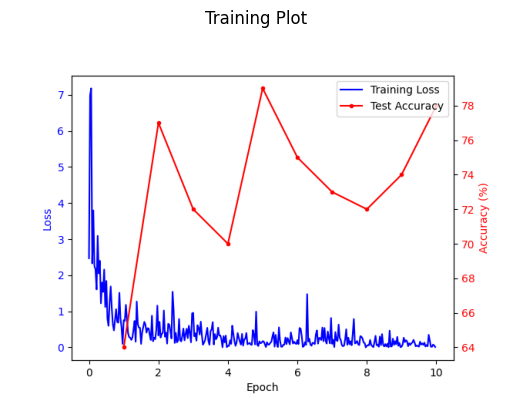

Class 0: 0.0000
Class 1: 0.0000
Class 2: 1.0000
Class 3: 0.0000
Class 4: 0.0000
Class 5: 0.0000
Class 6: 0.0000
Class 7: 0.0000
Class 8: 0.0000
Class 9: 0.0000

--- Prediction ---
True Label: 2
Predicted Label: 2 with confidence 1.0000


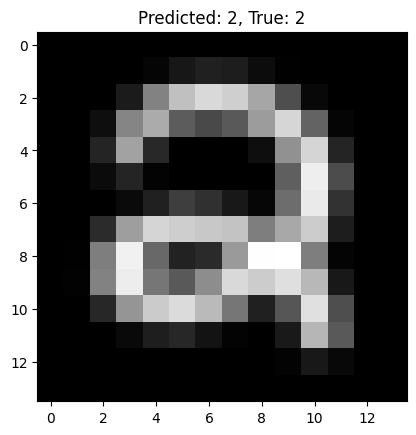

In [ ]:
# 4. Test prediction on a single image
# Load the model from file
model_from_path = load_model(filename)

# Select a random image from the full dataset
random_idx = random.randint(0, len(full_dataset) - 1)
img, label = full_dataset[random_idx]
img_batch = img.unsqueeze(0)  # Add batch dimension

predicted, confidence = predict_image(model_from_path, img_batch)
print(f"\n--- Prediction ---")
print(f"True Label: {label}")
print(f"Predicted Label: {predicted} with confidence {confidence:.4f}")

plt.imshow(img.squeeze(), cmap='gray')
plt.title(f"Predicted: {predicted}, True: {label}")
plt.show()

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.88      1.00      0.93         7
           2       0.45      0.62      0.53         8
           3       0.53      1.00      0.69         9
           4       1.00      0.71      0.83         7
           5       1.00      0.64      0.78        11
           6       0.92      1.00      0.96        12
           7       0.91      0.83      0.87        12
           8       0.83      0.33      0.48        15
           9       0.67      1.00      0.80         8

    accuracy                           0.78       100
   macro avg       0.82      0.81      0.78       100
weighted avg       0.83      0.78      0.77       100



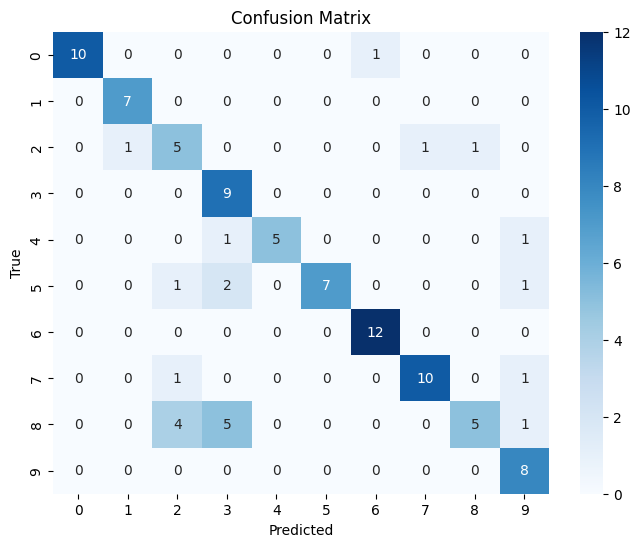

In [ ]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Collect all predictions and true labels from the test set
true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Define label names for MNIST
label_names = full_dataset.classes

# Print classification report
print(classification_report(true_labels, predicted_labels, target_names=label_names))

# Show confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()